## 1. import

In [8]:
import pandas as pd
import torch
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import numpy as np
import re
from collections import Counter
from itertools import chain
from autogluon.multimodal import MultiModalPredictor
from sklearn.utils.class_weight import compute_class_weight
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 2. 데이터 불러오기

In [2]:
# 데이터 불러오기
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
# [.] => .
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

In [4]:
display(train_df.head())
display(test_df.head())

,ID,URL,label
0,TRAIN_0000000,poznan.wuoz.gov.pl,0
1,TRAIN_0000001,vill.okawa.kochi.jp,0
2,TRAIN_0000002,nationalfinance.co.om,0
3,TRAIN_0000003,town.ozora.hokkaido.jp,0
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1


,ID,URL
0,TEST_0000000,niquelarte.blogspot.com.es
1,TEST_0000001,northernmetalproducts.com
2,TEST_0000002,ga.de
3,TEST_0000003,florawww.eeb.uconn.edu/199300089.html
4,TEST_0000004,activecity.moscow


## 3. 특성 공학(Feature-Engineering)

In [5]:
# 링크의 길이 계산
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

In [6]:
# ".", "/", "-"와 같은 특수문자 개수
train_df['special_char'] = train_df['URL'].map(lambda x: sum(1 for s in x if s in '.-/_'))
test_df['special_char'] = test_df['URL'].map(lambda x: sum(1 for s in x if s in '.-/_'))

In [7]:
# 악성 URL에 들어있는 문자들
train_df['words'] = train_df['URL'].map(lambda x: re.sub(r"[./\-_]", " ", x).split(' '))
test_df['words'] = test_df['URL'].map(lambda x: re.sub(r"[./\-_]", " ", x).split(' '))

In [8]:
# 악성 URL의 단어 포함 개수
word_list = list(chain.from_iterable(train_df['words'].values)) # 평탄화
word_list = set(word_list) # 중복 제거
word_list = [word for word in word_list if word.strip()] # 공백 제거

In [9]:
train_df.head()

,ID,URL,label,length,special_char,words
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,18,3,"[poznan, wuoz, gov, pl]"
1,TRAIN_0000001,vill.okawa.kochi.jp,0,19,3,"[vill, okawa, kochi, jp]"
2,TRAIN_0000002,nationalfinance.co.om,0,21,2,"[nationalfinance, co, om]"
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,22,3,"[town, ozora, hokkaido, jp]"
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,33,5,"[open24, ie, news, irish, online, Login]"


In [ ]:
predictor_1 = MultiModalPredictor(label='label', problem_type='binary')
predictor_2 = MultiModalPredictor(label='label', problem_type='binary')
predictor_3 = MultiModalPredictor(label='label', problem_type='binary')

In [6]:
# 라벨별 가중치 계산
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'].values)
weights /= weights.sum()
weights = list(weights)

In [ ]:
predictor_1.fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=None,
    column_types = {'URL':'text'},
    seed=42,
    hyperparameters={
        "model.hf_text.checkpoint_name": "r3ddkahili/final-complete-malicious-url-model",
        "env.per_gpu_batch_size": 32,
        "optimization.patience": 3,
        "optimization.loss_function": "focal_loss",
        "optimization.focal_loss.alpha": weights,
    }
)

In [ ]:
predictor_2.fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=None,
    column_types = {'URL':'text'},
    seed=42,
    hyperparameters={
        "model.hf_text.checkpoint_name": "CrabInHoney/urlbert-tiny-v3-malicious-url-classifier",
        "env.per_gpu_batch_size": 32,
        "optimization.patience": 3,
        "optimization.loss_function": "focal_loss",
        "optimization.focal_loss.alpha": weights,
    }
)

In [ ]:
predictor_3.fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=None,
    column_types = {'URL':'text'},
    seed=42,
    hyperparameters={
        "model.hf_text.checkpoint_name": "kmack/malicious-url-detection",
        "env.per_gpu_batch_size": 32,
        "optimization.patience": 3,
        "optimization.loss_function": "focal_loss",
        "optimization.focal_loss.alpha": weights,
    }
)

In [ ]:
preds_1 = predictor_1.predict_proba(
    test_df
)

In [ ]:
submission_df = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission_df['probability'] = preds[1]

In [ ]:
submission_df.to_csv('submission.csv', index=False)

In [14]:
from glob import glob
from itertools import combinations

model_list = sorted(glob('./data/'))
model_list
# pairs = list(combinations(model_list, 2))

# for pair in pairs:
#     print(pair[0], pair[1])

['./data/']

### EDA

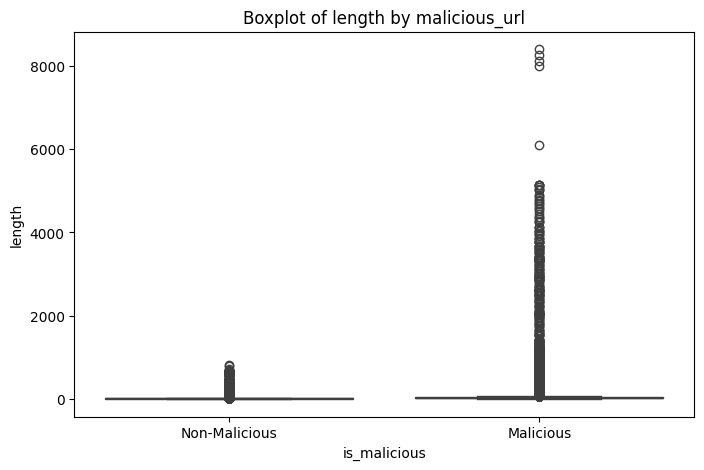

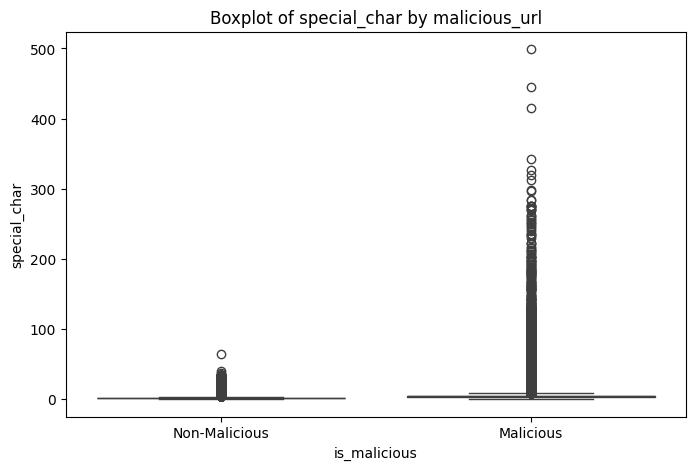

In [ ]:
# 길이, 특수문자의 개수에 따른 악성 URL 개수 분포
variables = ['length', 'special_char']

for var in variables:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f'Boxplot of {var} by malicious_url')
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.ylabel(var)
    plt.xlabel('is_malicious')
    plt.show()

* 악성 URL은 정상 URL에 비해 평균적으로 길이기 더 길다.
* 악성 URL은 정상 URL에 비해 특수 문자가 더 많이 포함되어있다.

### 상관관계 분석

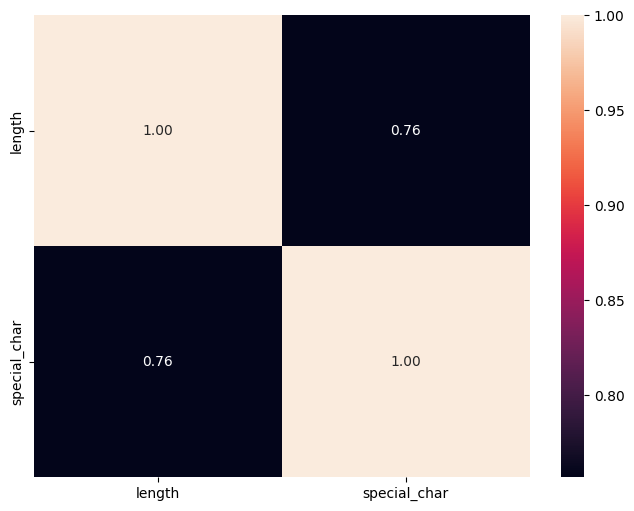

In [30]:
# 상관관계 분석
corr = train_df[['length', 'special_char']].corr()

# 히트맵
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()